# Import Base Packages

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Notebook Constants

In [2]:
POLYNOMIAL_ORDER = 2
INCLUDE_BIAS = False

DATASET_FILENAME = 'adult.csv'

TRAIN_TEST_SPLIT = 0.3
TREE_DEPTH = np.arange(1, 15)

RSKF_SPLITS = 2
RSKF_REPEATS = 2

RSKF_SPLITS_MODEL = 10
RSKF_REPEATS_MODEL = 1

PCA_MAX_COMPONENTS = 20

# Feature Engineering - preparation

## Columns separation

In [3]:
class Columns:
    
    def __init__(self):
        self.names = [ 'age', 'workclass', 'fnlwgt', 'education', 'educational-num', 
                        'marital-status', 'occupation', 'relationship', 'race', 
                        'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 
                        'native-country', 'income' ]
        self.to_drop = ['fnlwgt', 'education', 'native-country']
        self.to_encoding = [ 'workclass', 'marital-status', 'occupation',
                               'relationship', 'race', 'gender' ]
        self.to_normalize = [ 'age', 'educational-num', 'hours-per-week', 
                               'capital-gain', 'capital-loss' ]

## Function: to remove nan

Polynomial features can generate numbers that has no float64 representation, and it causes error during processing data.

In [4]:
def remove_nan(X, y):
    X_, y_ = [], []    
    for x, yt in zip(X, y):                
        if np.isnan(x).any() or np.isnan(yt).any():
            continue
        X_.append(x)
        y_.append(yt)        
    return np.array(X_), np.array(y_)

## Function that applies Feature Engineering

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

def feature_engineering(dataframe, polynomial_order=2, include_bias=False):
    le = LabelEncoder()
    scaler = StandardScaler()
    pl = PolynomialFeatures(polynomial_order, include_bias=include_bias)
    columns = Columns()

    df = dataframe
    df.drop(columns.to_drop, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=columns.to_encoding)
    df["income"] = le.fit_transform(df['income'])

    X_temp = pl.fit_transform(df[columns.to_normalize])
    X_temp = scaler.fit_transform(X_temp)
    df.drop(columns.to_normalize, axis=1, inplace=True)
    X = np.hstack((df.values, X_temp))
    y = df['income']
    columns_names = pl.get_feature_names(df.columns)
    X, y = remove_nan(X, y)
    return np.hstack((df.columns.values, columns_names)), X, y

# Data preparation

## Load dataset

In [6]:
dataframe = pd.read_csv(DATASET_FILENAME, index_col=False)

## Feature Engineering - execution

In [7]:
columns_names, X, y = feature_engineering(
                            dataframe, 
                            polynomial_order=POLYNOMIAL_ORDER, 
                            include_bias=INCLUDE_BIAS
                      )

## Split dataset

In [8]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT, random_state=42)
y.shape, y_test.shape

((34189,), (14653,))

# PCA: Principal Component Analysis


## Find the best components number - preparation

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score

param_distribution = {
    'max_depth': TREE_DEPTH,
}

scoring = {    
    'Accuracy': make_scorer(accuracy_score),
    'F1_Score': make_scorer(fbeta_score, beta=1, average='micro'),    
}

def apply_pca(fold, X_train,X_test,y_train,y_test, pca_max_components, rskf_splits, rskf_repeats, debug=True):
    results = []
    for i in range(1, pca_max_components + 1):
        # train
        pca = PCA(i)
        X_t = pca.fit_transform(X_train)
        kf_temp = RepeatedStratifiedKFold(n_splits=rskf_splits, n_repeats=rskf_repeats)
        search_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_distribution,
                                       scoring=scoring, n_jobs=-1, 
                                       cv=kf_temp, 
                                       refit='F1_Score') 
        search_cv.fit(X_t, y_train)
        model = search_cv.best_estimator_        

        # test
        X_t = pca.transform(X_test)
        y_pred = model.predict(X_t)

        # model evaluation
        f1 = fbeta_score(y_test, y_pred, beta=1)
        acc = accuracy_score(y_test, y_pred)

        if debug:
            print(f"fold: {fold} - cp:{i} train: {search_cv.best_score_} test: f1={f1}, acc={acc}")
        results.append((fold, i, acc, f1, pca, model))
    return results

## Find the best components number - execution

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def best_components_number(X, y, pca_max_components, rskf_splits, rskf_repeats):
    result = []
    kf = RepeatedStratifiedKFold(n_splits=rskf_splits, n_repeats=rskf_repeats)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_tr, X_tst = X[train_index], X[test_index]
        y_tr, y_tst = y[train_index], y[test_index]

        result_ = apply_pca(fold, X_tr, X_tst, y_tr, y_tst, pca_max_components, rskf_splits, rskf_repeats)
        result += result_ # concatenate
    
    # get from highest f1 score the number of components used
    best_f1 = 0
    best_model = None
    for fold, n, acc, f1, pca, model in result:
        if best_f1 < f1:
            best_f1 = f1
            best_model=(fold, n, acc, f1, pca, model)
    pca_components = best_model[1]
    return pca_components

pca_components = best_components_number(X, y, PCA_MAX_COMPONENTS, RSKF_SPLITS, RSKF_REPEATS)
print(f'Best number of components: {pca_components}')

fold: 0 - cp:1 train: 0.8099333099333099 test: f1=0.5096167751265365, acc=0.8016379058204153
fold: 0 - cp:2 train: 0.8226863226863227 test: f1=0.5504457336918069, acc=0.8141561860193038
fold: 0 - cp:3 train: 0.8266643266643267 test: f1=0.6509279131422799, acc=0.8382568002339865
fold: 0 - cp:4 train: 0.8221305721305722 test: f1=0.6187624750499001, acc=0.832407136589646
fold: 0 - cp:5 train: 0.8322510822510822 test: f1=0.6905883774314366, acc=0.850190114068441
fold: 0 - cp:6 train: 0.8922428922428922 test: f1=0.7885468136323324, acc=0.9023691137759579
fold: 0 - cp:7 train: 0.9170469170469171 test: f1=0.8505032931527277, acc=0.9296285463585844
fold: 0 - cp:8 train: 0.9146191646191646 test: f1=0.8459530026109661, acc=0.9275226674466218
fold: 0 - cp:9 train: 0.9142681642681643 test: f1=0.8379705400981997, acc=0.9247148288973384
fold: 0 - cp:10 train: 0.9135369135369136 test: f1=0.8382887968887216, acc=0.9245978356244516
fold: 0 - cp:11 train: 0.9558324558324558 test: f1=0.9183475091130011, 

# Get best model with best pca_components number

In [11]:
def get_best_model(pca_components, rskf_splits, rskf_repeats):
    result, metrics = [], []
    kf = RepeatedStratifiedKFold(n_splits=rskf_splits, n_repeats=rskf_repeats)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # train
        pca = PCA(pca_components)
        X_t = pca.fit_transform(X_train)
        search_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_distribution,
                                       scoring=scoring, n_jobs=-1, 
                                       cv=RepeatedStratifiedKFold(
                                           n_splits=rskf_splits, 
                                           n_repeats=rskf_repeats), 
                                       refit='F1_Score') 
        search_cv.fit(X_t, y_train)
        model = search_cv.best_estimator_        

        # test
        X_t = pca.transform(X_test)
        y_pred = model.predict(X_t)

        # model evaluation
        f1 = fbeta_score(y_test, y_pred, beta=1)
        acc = accuracy_score(y_test, y_pred)

        print(f"fold: {fold} - cp:{pca_components} train: {search_cv.best_score_} test: f1={f1}, acc={acc}")

        result.append((X_train, y_train, X_test, y_test, fold, acc, f1, pca, model))        
        metrics.append((f1, acc))

    best_f1 = 0
    best_model = None
    for X_train, y_train, X_test, y_test, fold, acc, f1, pca, model in result:
        if best_f1 < f1:
            best_f1 = f1
            best_model=(X_train, y_train, X_test, y_test, metrics, fold, acc, f1, pca, model)
    return best_model

best_model = get_best_model(pca_components,  RSKF_SPLITS_MODEL, RSKF_REPEATS_MODEL)

fold: 0 - cp:20 train: 0.989209919074393 test: f1=0.9788263762855415, acc=0.9897660818713451
fold: 1 - cp:20 train: 0.9899899249244369 test: f1=0.9836660617059891, acc=0.9921052631578947
fold: 2 - cp:20 train: 0.9887227819304517 test: f1=0.9776164549304295, acc=0.9891781222579702
fold: 3 - cp:20 train: 0.9899252518687033 test: f1=0.9795180722891567, acc=0.9900555718046212
fold: 4 - cp:20 train: 0.9894377640558986 test: f1=0.9737324373854612, acc=0.987423223164668
fold: 5 - cp:20 train: 0.9900877478063048 test: f1=0.9818401937046005, acc=0.9912255045334893
fold: 6 - cp:20 train: 0.9905427364315892 test: f1=0.9769975786924939, acc=0.9888856390757531
fold: 7 - cp:20 train: 0.9894706054401872 test: f1=0.9800604229607252, acc=0.9903452311293154
fold: 8 - cp:20 train: 0.9890156316011829 test: f1=0.9756986634264885, acc=0.9882972498537156
fold: 9 - cp:20 train: 0.9896330960969745 test: f1=0.9762050030506407, acc=0.9885898186073727


# Analyse Model Result

## AUC

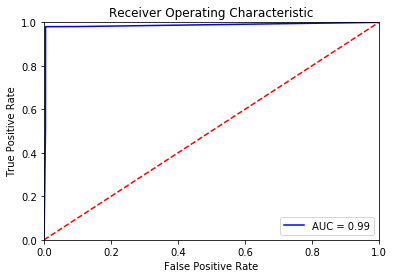

In [12]:
from sklearn import metrics

pca, model = best_model[-2], best_model[-1]
probs = model.predict_proba(pca.transform(X_test))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Score by Fold

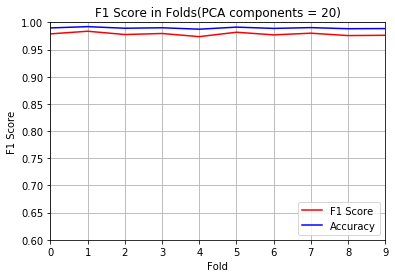

In [13]:
f1_r, acc_r = [], []
for f1, acc in best_model[4]:
    f1_r.append(f1)
    acc_r.append(acc)

f1_r, acc_r = np.array(f1_r), np.array(acc_r)
l = f1_r.shape[0]
plt.title(f'F1 Score in Folds(PCA components = {pca_components})')
plt.plot(range(l), f1_r, 'r', label = 'F1 Score')
plt.plot(range(l), acc_r, 'b', label = 'Accuracy')
plt.legend(loc = 'lower right')
plt.xticks(range(l))
plt.xlim([0, l - 1])
plt.ylim([0.60, 1])
plt.ylabel('F1 Score')
plt.xlabel('Fold')
plt.grid()
plt.show()

## Plot feature importances

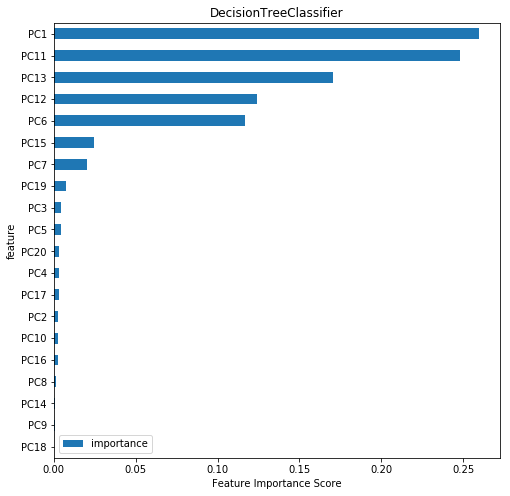

In [14]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
#     https://www.kaggle.com/grfiv4/plotting-feature-importances
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    X_train = pd.DataFrame(data=X_train, columns=[f"PC{i}" for i in range(1, X_train.shape[1] + 1)])
    
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

pca, clf = best_model[-2], best_model[-1]
feature_importance = plot_feature_importances(clf, pca.transform(X), top_n=X.shape[1], title=clf.__class__.__name__)

## Get Features Used to Generate PCA Components

In [15]:
# https://stackoverflow.com/questions/22348668/pca-decomposition-with-python-features-relevances
pca, clf = best_model[-2], best_model[-1]
index_components = [int(x[2:]) for x in feature_importance.index.values]
def features_used_to_generate_pca_components(index_components, pca, clf, columns_names):    
    for i in index_components:
        index_features = np.abs(pca.components_[i - 1]).argsort()[:4]
        features = columns_names[index_features]
        print(f'PC{i}')
        print(f'Features:')
        for f in features:
            print("\t" + f)
        print()
        
features_used_to_generate_pca_components(index_components, pca, clf, columns_names)

PC18
Features:
	workclass_Local-gov workclass_Never-worked
	workclass_Never-worked
	occupation_Armed-Forces
	occupation_Tech-support

PC9
Features:
	workclass_Local-gov workclass_Never-worked
	workclass_Never-worked
	occupation_Armed-Forces
	workclass_Without-pay

PC14
Features:
	workclass_Local-gov workclass_Never-worked
	marital-status_Married-AF-spouse
	income
	occupation_Armed-Forces

PC8
Features:
	workclass_Local-gov workclass_Never-worked
	workclass_Never-worked
	marital-status_Married-AF-spouse
	income workclass_Never-worked

PC16
Features:
	workclass_Local-gov workclass_Never-worked
	workclass_Never-worked
	occupation_Armed-Forces
	workclass_Without-pay

PC10
Features:
	workclass_Local-gov workclass_Never-worked
	workclass_Never-worked
	occupation_Armed-Forces
	marital-status_Married-AF-spouse

PC2
Features:
	workclass_Local-gov workclass_Never-worked
	occupation_Priv-house-serv
	workclass_Never-worked
	workclass_Without-pay

PC17
Features:
	workclass_Local-gov workclass_Never

## Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

pca, clf = best_model[-2], best_model[-1]

y_pred = clf.predict(pca.transform(X_test))

cm = confusion_matrix(y_test, y_pred)
cm

array([[11183,    50],
       [   68,  3352]])

Normalized confusion matrix
[[0.99554883 0.00445117]
 [0.01988304 0.98011696]]


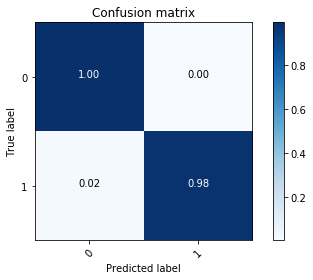

In [17]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(cm, [0, 1], True)

## Classification Report

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11233
           1       0.99      0.98      0.98      3420

   micro avg       0.99      0.99      0.99     14653
   macro avg       0.99      0.99      0.99     14653
weighted avg       0.99      0.99      0.99     14653



# Save Best Model

In [19]:
from sklearn.externals import joblib

joblib.dump(best_model, 'lgr.joblib')

['lgr.joblib']